In [194]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from math import ceil
import psycopg2 as pg
import psycopg2.extras
import pandas.io.sql as sqlio

# 1. Dimension _'Date'_
## 1.1. Reading data into Python

**Read listings_al.csv**, which has the dates needed for the listings fact table.

In [195]:
# read listings_al.csv data file
listings_al_file_path = '../data/listings_al.csv'
df_listings = pd.read_csv(listings_al_file_path,sep=',')

C:\Users\joao_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Read calendar.csv file**, which has the dates needed for the availability fact table.

In [196]:
# read calendar.csv data file
calendar_file_path = '../data/airbnb/calendar.csv'
df_calendar = pd.read_csv(calendar_file_path,sep=',')

Convert string to date

In [197]:
# convert string to date
df_listings['DataRegisto'] = [datetime.strptime(d.split('.')[0], "%Y-%m-%dT%H:%M:%S") for d in df_listings['DataRegisto']] # split into YYYY-MM-DD HH:MM:SS
df_listings.shape

(17168, 147)

In [198]:
df_calendar['date'] = [datetime.strptime(d, "%Y-%m-%d") for d in df_calendar['date']] # split into YYYY-MM-DD
df_calendar.shape

(7190661, 7)

In [199]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,286500,2020-02-14,f,$150.00,$150.00,3.0,365.0
1,69042,2020-02-14,f,$130.00,$130.00,3.0,365.0
2,69042,2020-02-15,f,$130.00,$130.00,3.0,365.0
3,69042,2020-02-16,t,$130.00,$130.00,2.0,365.0
4,69042,2020-02-17,f,$130.00,$130.00,2.0,365.0


In _calendar.csv_, there are approximately 365 records for each listing. Each record indicates if the listing is available in that day.

Now lets drop the duplicates from df_calendar. 

In [200]:
# remove df_calendar duplicates
df_calendar = df_calendar.drop_duplicates(subset=['date'])
df_calendar.shape

(366, 7)

## 1.2. Exploratory data analysis

We do a quick exploration of the data available in _listings_al.csv_.

In [201]:
# count by year
years = [d.year for d in df_listings['DataRegisto']] # makes list of year in each listing's date
df_years = pd.DataFrame(years,columns=['year']) # convert to dataframe
df_years_graph = df_years.year.value_counts().to_frame('count').reset_index().rename(columns={'index': 'year'}).sort_values('year',ascending = True) # count each year, sort by asc.

# remove count of 2020 because it is incomplete (data exported from inside airbnb in january)
df_years_graph = df_years_graph[df_years_graph['year']!=2020]

# create column with the cumulative sum
df_years_graph['cum_count'] = df_years_graph['count'].cumsum()

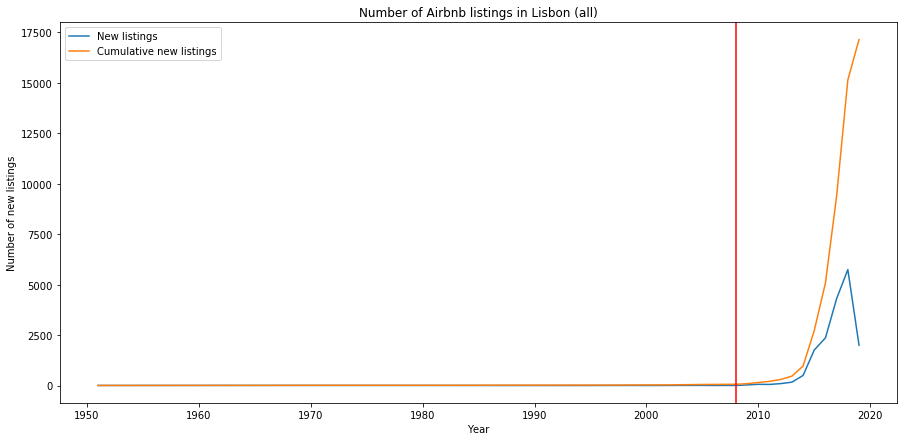

In [202]:
plt.figure(figsize=(15,7))
plt.plot(df_years_graph['year'],df_years_graph['count'], label = 'New listings')
plt.plot(df_years_graph['year'],df_years_graph['cum_count'], label = 'Cumulative new listings')
plt.axvline(x = 2008, color = 'red')
plt.xlabel('Year')
plt.ylabel('Number of new listings')
plt.title('Number of Airbnb listings in Lisbon (all)')
plt.legend()

It seems a negligible part of the properties were registered before 2010 for lodging. This already gives us some insights: there was a clear boom in property registration with the intention to host tourists after Airbnb was created in 2008 (red line). Data from 2020 was neglected as it is incomplete (the dataset was scraped in January).

Let's plot the data just from 2010 forward.

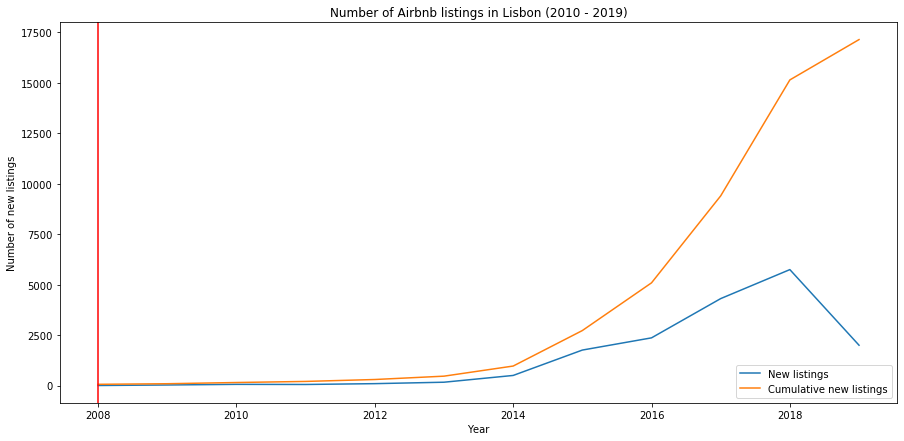

In [203]:
df_years_graph2010 = df_years_graph[df_years_graph['year']>= 2008]
plt.figure(figsize=(15,7))
plt.plot(df_years_graph2010['year'],df_years_graph2010['count'], label = 'New listings')
plt.plot(df_years_graph2010['year'],df_years_graph2010['cum_count'], label = 'Cumulative new listings')
plt.axvline(x = 2008, color = 'red')
plt.xlabel('Year')
plt.ylabel('Number of new listings')
plt.title('Number of Airbnb listings in Lisbon (2010 - 2019)')
plt.legend()

We can see that since 2013, the number of new listings in airbnb for Lisbon increased until 2018, from less than 500 new listings per year to more than 5000 new listings per year, which is a 10x increase. In 2019 the growth in new listings decreased compared to the previous year.

In [204]:
df_years_graph2010

,year,count,cum_count
21,2008,3,62
10,2009,29,91
8,2010,60,151
9,2011,54,205
7,2012,95,300
6,2013,166,466
5,2014,501,967
4,2015,1759,2726
2,2016,2364,5090
1,2017,4309,9399


In 2010 there were 151 listings in Airbnb located in Lisbon, and in 2019 there was a total of 17155 listings, which is an increase of about 113 times.

## 1.3. Preprocessing

Now, let's preprocess the data in order to create our dimension. The dimension _'Date'_ has the following schema:

<img src="date_schema.png" width="150" align="center"/>

We start by defining functions that process each date and build its respective attributes in the dimension.

In [205]:
def date_season(month):
    """Detects the season of the year the date belongs to"""
    if (month < 3) or (month == 12): return 'Winter'
    elif (month >= 3) and (month < 6): return 'Spring'
    elif (month >= 6) and (month < 9): return 'Summer'
    elif (month >= 9) and (month < 12): return 'Autumn'

def date_weekend(week_day):
    """Detects if date is work day or weekend"""
    if (week_day == 5) or (week_day == 6): return 'Weekend'
    else: return 'Work Day'

def week_day(d):
    """Detects weekday"""
    days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    return days[d.weekday()]

def date_pk(date):
    """Builds primary key"""
    return int(date.strftime('%d%m%Y'))

def week_of_month(dt):
    """Detects the week of the month for the specified date"""
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

def getQuarter(d):
    """Detects which quarter of the year date belongs to"""
    if d.month<=3: return "Q1"
    if d.month<=6: return "Q2"
    if d.month<=9: return "Q3"
    return "Q4"

def getSemester(d):
    """Detects which semester of the year date belongs to"""
    if d.month<=6: return "S1"
    return "S2"

def is_holiday(d):
    if len(df_holidays2[(df_holidays2['Day']==d.day) & (df_holidays2['Month']==d.month)])>0: return 'Holiday'
    else: return 'Not Holiday'

Example of date dimension primary key in format 'ddMMyyyy'

In [206]:
df_listings['DataRegisto'][0], date_pk(df_listings['DataRegisto'][0])

(Timestamp('2017-09-13 13:40:58'), 13092017)

### 1.3.1 Preprocessing *feriados_nacionais.csv* data

In [207]:
holiday_file_path = '../data/feriados_nacionais.csv'
df_holidays = pd.read_csv(holiday_file_path)
df_holidays.head()

,Title,Given planned earliest start,Given planned earliest end,Notes,Assigned Resources,Additional Title
0,Ano Novo,1/1/2020,1/1/2020,feriado nacional em Portugal | feriados.com.pt...,NaN,NaN
1,Carnaval,2/24/2020,2/24/2020,feriado regional | feriados.com.pt. All data w...,NaN,NaN
2,Sexta-Feira Santa,4/10/2020,4/10/2020,feriado nacional em Portugal | feriados.com.pt...,NaN,NaN
3,Páscoa,4/12/2020,4/12/2020,feriado nacional em Portugal | feriados.com.pt...,NaN,NaN
4,Segunda-feira de Páscoa,4/13/2020,4/13/2020,feriado regional | feriados.com.pt. All data w...,NaN,NaN


Preprocess the file in order to get a clean dataframe with the holidays

In [208]:
holidays_dates = df_holidays.iloc[:,1].values[:-1]
holidays_dates = [datetime.strptime(d, "%m/%d/%Y") for d in holidays_dates]

holidays_days = [d.day for d in holidays_dates]
holidays_months = [d.month for d in holidays_dates]

df_holidays2 = pd.DataFrame(np.stack((holidays_days,holidays_months), axis = 1),columns=['Day','Month'])
df_holidays2

,Day,Month
0,1,1
1,24,2
2,10,4
3,12,4
4,13,4
5,25,4
6,1,5
7,21,5
8,10,6
9,11,6


The data in this dataframe will be used in order to fed the 'Holiday' column of the dimension.

### 1.3.2 Processing the _df_listings_ data

In [209]:
pks = [date_pk(d) for d in df_listings['DataRegisto']]
days = [d.day for d in df_listings['DataRegisto']]
weeks = [week_of_month(d) for d in df_listings['DataRegisto']]
week_days = [week_day(d) for d in df_listings['DataRegisto']]
week_ends = [date_weekend(d.weekday()) for d in df_listings['DataRegisto']]
months = [d.month for d in df_listings['DataRegisto']]
seasons = [date_season(d.month) for d in df_listings['DataRegisto']]
quarters = [getQuarter(d) for d in df_listings['DataRegisto']]
semesters = [getSemester(d) for d in df_listings['DataRegisto']]
holidays = [is_holiday(d) for d in df_listings['DataRegisto']]

After processing each date in the dataframe and building a list of values for each attribute, we merge them together in a DataFrame.

In [210]:
columns = ['date_id','day','week', 'month','year','season','weekend','weekday','quarter','semester','holiday']
df_date_dimension = pd.DataFrame(np.stack((pks,days,weeks, months,years, seasons,week_ends,week_days,quarters,semesters,holidays),axis=-1), columns = columns)
df_date_dimension.shape

(17168, 11)

In [211]:
df_date_dimension.head()

,date_id,day,week,month,year,season,weekend,weekday,quarter,semester,holiday
0,13092017,13,3,9,2017,Autumn,Work Day,Wednesday,Q3,S2,Not Holiday
1,15012016,15,3,1,2016,Winter,Work Day,Friday,Q1,S1,Not Holiday
2,12052016,12,3,5,2016,Spring,Work Day,Thursday,Q2,S1,Not Holiday
3,31082017,31,5,8,2017,Summer,Work Day,Thursday,Q3,S2,Not Holiday
4,31082017,31,5,8,2017,Summer,Work Day,Thursday,Q3,S2,Not Holiday


Removal of duplicates

In [212]:
df_date_dimension = df_date_dimension.drop_duplicates(subset=['date_id'])
df_date_dimension.shape

(1826, 11)

### 1.3.3 Processing the _df_calendar_ data

In [213]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,286500,2020-02-14,f,$150.00,$150.00,3.0,365.0
2,69042,2020-02-15,f,$130.00,$130.00,3.0,365.0
3,69042,2020-02-16,t,$130.00,$130.00,2.0,365.0
4,69042,2020-02-17,f,$130.00,$130.00,2.0,365.0
5,69042,2020-02-18,f,$130.00,$130.00,2.0,365.0


In [214]:
pks2 = [date_pk(d) for d in df_calendar['date']]
days2 = [d.day for d in df_calendar['date']]
weeks2 = [week_of_month(d) for d in df_calendar['date']]
week_days2 = [week_day(d) for d in df_calendar['date']]
week_ends2 = [date_weekend(d.weekday()) for d in df_calendar['date']]
months2 = [d.month for d in df_calendar['date']]
seasons2 = [date_season(d.month) for d in df_calendar['date']]
quarters2 = [getQuarter(d) for d in df_calendar['date']]
semesters2 = [getSemester(d) for d in df_calendar['date']]
years2 = [d.year for d in df_calendar['date']]
holidays2 = [is_holiday(d) for d in df_calendar['date']]

Merge the two dataframes (dates needed both for availability and listing facts)

In [215]:
df_date_dimension_insert = pd.concat([pd.DataFrame(np.stack((pks2,days2,weeks2,months2,years2,seasons2,week_ends2,week_days2,quarters2,semesters2,holidays2),axis=-1), columns = columns),df_date_dimension])
df_date_dimension_insert

,date_id,day,week,month,year,season,weekend,weekday,quarter,semester,holiday
0,14022020,14,3,2,2020,Winter,Work Day,Friday,Q1,S1,Not Holiday
1,15022020,15,3,2,2020,Winter,Weekend,Saturday,Q1,S1,Not Holiday
2,16022020,16,3,2,2020,Winter,Weekend,Sunday,Q1,S1,Not Holiday
3,17022020,17,4,2,2020,Winter,Work Day,Monday,Q1,S1,Not Holiday
4,18022020,18,4,2,2020,Winter,Work Day,Tuesday,Q1,S1,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...
17150,14032013,14,3,3,2013,Spring,Work Day,Thursday,Q1,S1,Not Holiday
17153,18012020,18,3,1,2020,Winter,Weekend,Saturday,Q1,S1,Not Holiday
17155,22012020,22,4,1,2020,Winter,Work Day,Wednesday,Q1,S1,Not Holiday
17157,21012020,21,4,1,2020,Winter,Work Day,Tuesday,Q1,S1,Not Holiday


## 1.4 Insert data into DB

Connection settings

In [223]:
df_date_dimension_insert

,date_id,day,week,month,year,season,weekend,weekday,quarter,semester,holiday
0,14022020,14,3,2,2020,Winter,Work Day,Friday,Q1,S1,Not Holiday
1,15022020,15,3,2,2020,Winter,Weekend,Saturday,Q1,S1,Not Holiday
2,16022020,16,3,2,2020,Winter,Weekend,Sunday,Q1,S1,Not Holiday
3,17022020,17,4,2,2020,Winter,Work Day,Monday,Q1,S1,Not Holiday
4,18022020,18,4,2,2020,Winter,Work Day,Tuesday,Q1,S1,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...
17150,14032013,14,3,3,2013,Spring,Work Day,Thursday,Q1,S1,Not Holiday
17153,18012020,18,3,1,2020,Winter,Weekend,Saturday,Q1,S1,Not Holiday
17155,22012020,22,4,1,2020,Winter,Work Day,Wednesday,Q1,S1,Not Holiday
17157,21012020,21,4,1,2020,Winter,Work Day,Tuesday,Q1,S1,Not Holiday


In [224]:
use_local = True
server_host = "appserver-01.alunos.di.fc.ul.pt" if use_local == False else "localhost"
port = 5432
sslmode = "allow" if use_local == False else "disable"
dbname = "tpd012" if use_local == False else "postgres"
dbusername = "tpd012" if use_local == False else "postgres"
dbpassword = "Airbnbosses69420" if use_local == False else "h9qoipj2"

In [225]:
# function to query table and convert it to pandas dataframe
def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {};".format(table_name)
    #return dataframe
    return sqlio.read_sql_query(sql, conn)

# for this function to run, the dataframes must have the same columns, in the same order
def get_data_to_insert(df_etl, df_sql,pk):
    """Returns data valid for insertion in dimension from a new ETL-processed DataFrame"""
    df_insert = df_etl[-df_etl[pk].astype(int).isin(df_sql[pk].astype(int))].dropna(how = 'all')
    df_insert = df_insert.drop_duplicates(subset=[pk], keep=False)
    return df_insert
# function for bulk insert
def insert_data(df, table_name, conn):
    """Inserts selected data into dimension table in database"""
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        psycopg2.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except pg.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

Get date dimension data from postgres db server

In [226]:
conn = pg.connect(host = server_host,database = dbname, user = dbusername,password = dbpassword, sslmode = sslmode)
df_date_dimension_sql = query_table(conn, 'date')
conn.close()
df_date_dimension_sql.head()

,date_id,day,week,month,year,season,weekend,weekday,quarter,semester,holiday
0,14022020,14,3,2,2020,Winter,Work Day,Friday,Q1,S1,Not Holiday
1,15022020,15,3,2,2020,Winter,Weekend,Saturday,Q1,S1,Not Holiday
2,16022020,16,3,2,2020,Winter,Weekend,Sunday,Q1,S1,Not Holiday
3,17022020,17,4,2,2020,Winter,Work Day,Monday,Q1,S1,Not Holiday
4,18022020,18,4,2,2020,Winter,Work Day,Tuesday,Q1,S1,Not Holiday


Guarantee that duplicates will be not be inserted, by getting just the data in dataframe with the ETL output (df_date_dimension_insert) that is not in df_sql.

In [227]:
df_insert = get_data_to_insert(df_date_dimension_insert,df_date_dimension_sql,'date_id')
df_insert

,date_id,day,week,month,year,season,weekend,weekday,quarter,semester,holiday


Insert data into database

In [228]:
if len(df_insert) > 0:
    table_name = 'date'
    conn = pg.connect(host = server_host,database = dbname, user = dbusername,password = dbpassword, sslmode = sslmode)
    success = insert_data(df_insert,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')

No data to insert
